<a href="https://colab.research.google.com/github/Fairim/University/blob/main/HM6SQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

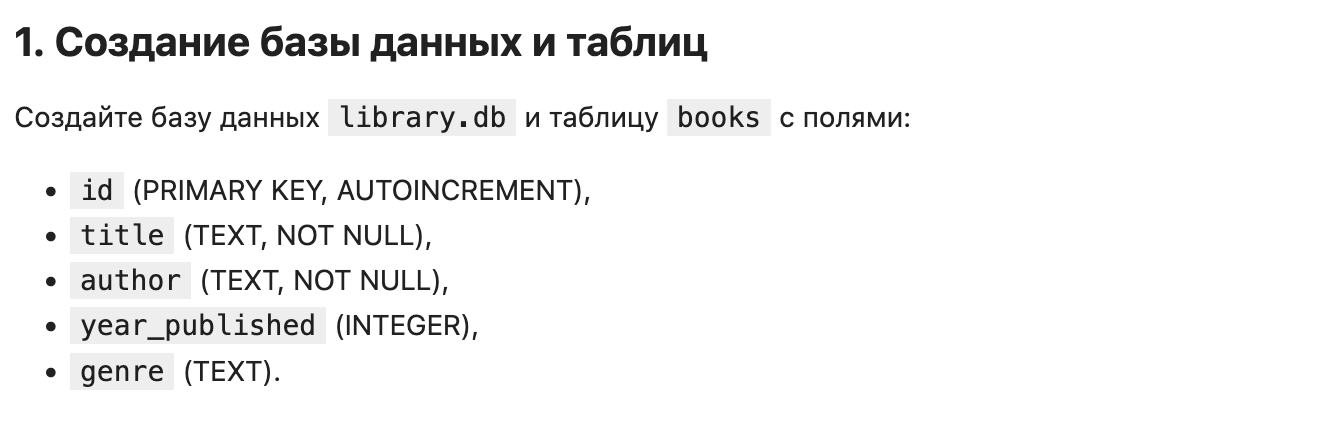

In [155]:
import sqlite3

conn = sqlite3.connect('library.db')

cursor = conn.cursor()

query = """
CREATE TABLE IF NOT EXISTS books(
  id INTEGER PRIMARY KEY AUTOINCREMENT,
  title TEXT NOT NULL,
  author TEXT NOT NULL,
  year_published INTEGER NOT NULL,
  genre TEXT
)
"""

cursor.execute(query)
conn.commit()
conn.close()

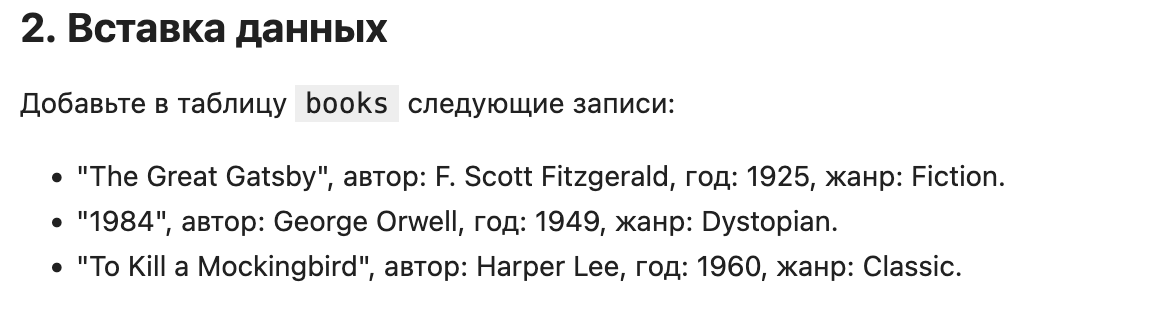

In [156]:
conn = sqlite3.connect('library.db')

cursor = conn.cursor()

add_query = """
INSERT INTO books (title, author, year_published, genre)
VALUES (?, ?, ?, ?)
"""

var1 = ("The Great Gatsby", "F. Scott Fitzgerald", 1925, "Fiction")
var2 = ("1984", "George Orwell", 1949, "Dystopian")
var3 = ("To Kill a Mockingbird", "Harper Lee", 1960, "Classic")

cursor.execute(add_query, var1)
cursor.execute(add_query, var2)
cursor.execute(add_query, var3)
conn.commit()

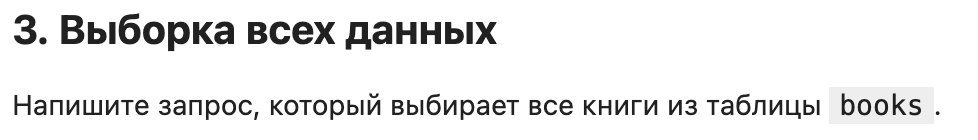

In [157]:
import pandas as pd
query = """
SELECT *
FROM books
"""
df = pd.read_sql(query, conn)
df

,id,title,author,year_published,genre
0,1,The Great Gatsby,F. Scott Fitzgerald,1925,Fiction
1,2,1984,George Orwell,1949,Dystopian
2,3,To Kill a Mockingbird,Harper Lee,1960,Classic


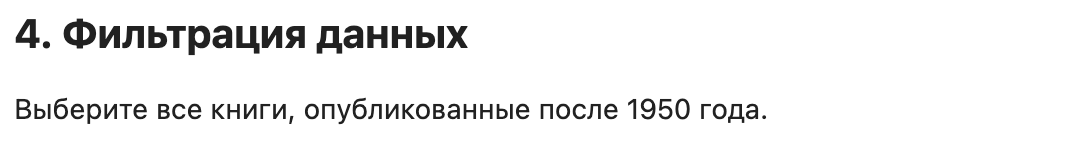

In [158]:
query = """
SELECT *
FROM books
WHERE year_published > 1950
"""

df = pd.read_sql(query, conn)
df

,id,title,author,year_published,genre
0,3,To Kill a Mockingbird,Harper Lee,1960,Classic


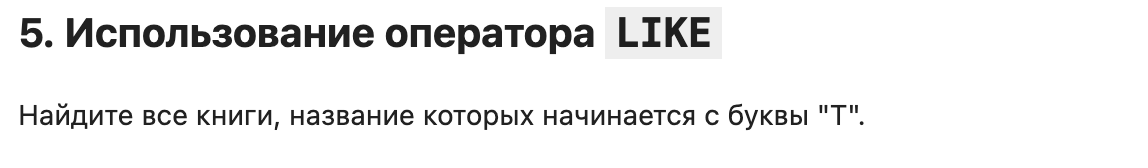

In [159]:
query = """
SELECT *
FROM books
WHERE title LIKE "T%"
"""

df = pd.read_sql(query, conn)
df

,id,title,author,year_published,genre
0,1,The Great Gatsby,F. Scott Fitzgerald,1925,Fiction
1,3,To Kill a Mockingbird,Harper Lee,1960,Classic


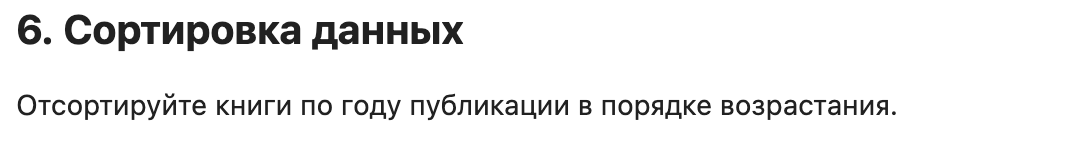

In [160]:
query = """
SELECT *
FROM books
ORDER BY year_published
"""

df = pd.read_sql(query, conn)
df

,id,title,author,year_published,genre
0,1,The Great Gatsby,F. Scott Fitzgerald,1925,Fiction
1,2,1984,George Orwell,1949,Dystopian
2,3,To Kill a Mockingbird,Harper Lee,1960,Classic


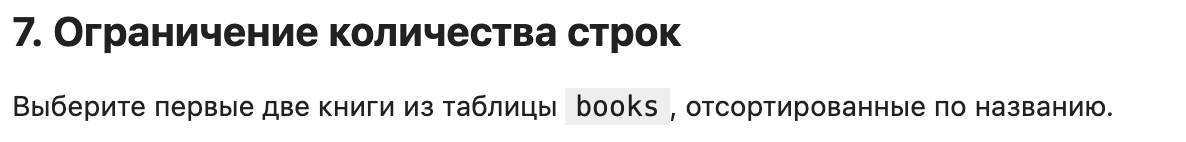

In [161]:
query = """
SELECT *
FROM books
ORDER BY title
LIMIT 2
"""

df = pd.read_sql(query, conn)
df

,id,title,author,year_published,genre
0,2,1984,George Orwell,1949,Dystopian
1,1,The Great Gatsby,F. Scott Fitzgerald,1925,Fiction


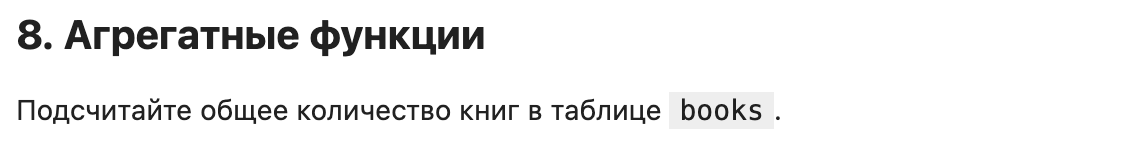

In [162]:
query = """
SELECT COUNT(*) AS count
FROM books
"""

df = pd.read_sql(query, conn)
df

,count
0,3


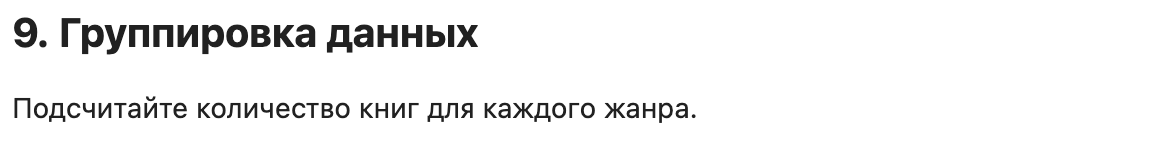

In [163]:
query = """
SELECT genre, COUNT(*) AS count
FROM books
GROUP BY genre
"""

df = pd.read_sql(query, conn)
df

,genre,count
0,Classic,1
1,Dystopian,1
2,Fiction,1


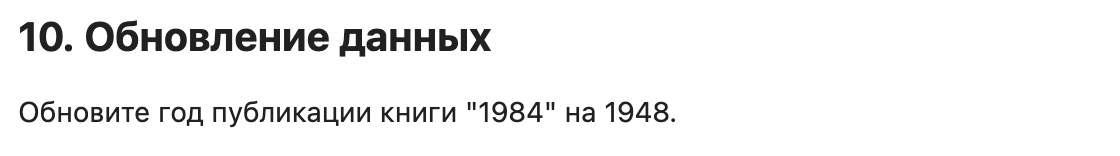

In [164]:
cursor.execute("""
UPDATE books
SET year_published = 1984
WHERE title = "1984"
""")

conn.commit()

query = """
SELECT *
FROM books
"""

df = pd.read_sql(query, conn)
df

,id,title,author,year_published,genre
0,1,The Great Gatsby,F. Scott Fitzgerald,1925,Fiction
1,2,1984,George Orwell,1984,Dystopian
2,3,To Kill a Mockingbird,Harper Lee,1960,Classic


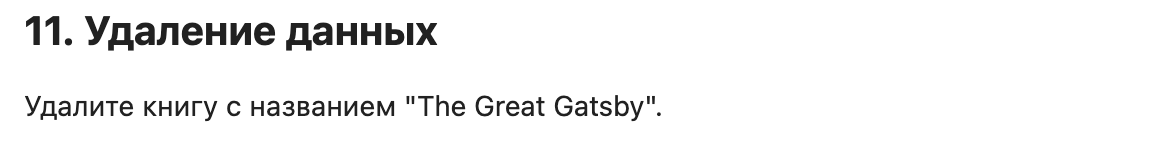

In [165]:
cursor.execute("""
DELETE FROM books
WHERE title = "The Great Gatsby"
""")

conn.commit()

query = """
SELECT *
FROM books
"""

df = pd.read_sql(query, conn)
df

,id,title,author,year_published,genre
0,2,1984,George Orwell,1984,Dystopian
1,3,To Kill a Mockingbird,Harper Lee,1960,Classic


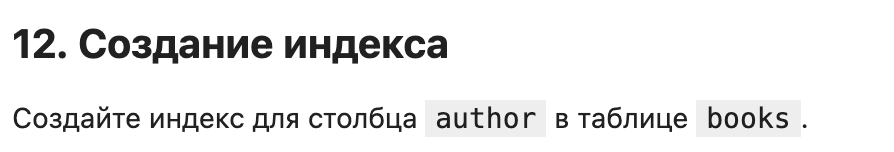

In [166]:
cursor.execute("""
CREATE INDEX IF NOT EXISTS idx_books_author
ON books (author);
""")

conn.commit()

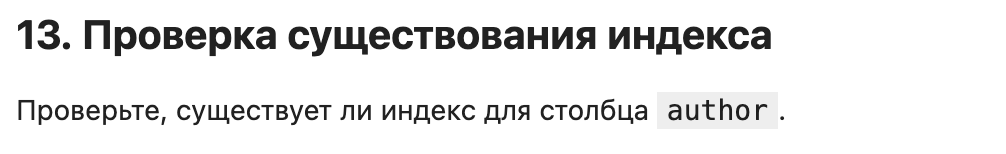

In [167]:
query = """
SELECT name
FROM sqlite_master
WHERE type='index' AND name='idx_books_author'
"""

df = pd.read_sql(query, conn)
df

,name
0,idx_books_author


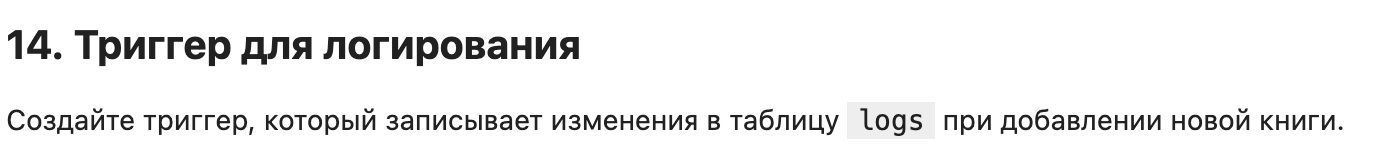

In [168]:
cursor.execute('''
CREATE TABLE IF NOT EXISTS books_logs (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    book_id INTEGER,
    action TEXT,
    timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
);
''')

cursor.execute('''
CREATE TRIGGER IF NOT EXISTS log_books_changes
AFTER INSERT ON books
FOR EACH ROW
BEGIN
    INSERT INTO books_logs (book_id, action)
    VALUES (NEW.id, 'INSERT');
END;
''')


cursor.execute("""
INSERT INTO books (title, author, year_published, genre)
VALUES (?, ?, ?, ?);
""", ("The Great Gatsby", "F. Scott Fitzgerald", 1925, "Fiction"))

query = """
SELECT *
FROM books_logs
"""

df = pd.read_sql(query, conn)
df

,id,book_id,action,timestamp
0,1,4,INSERT,2025-04-22 08:07:58


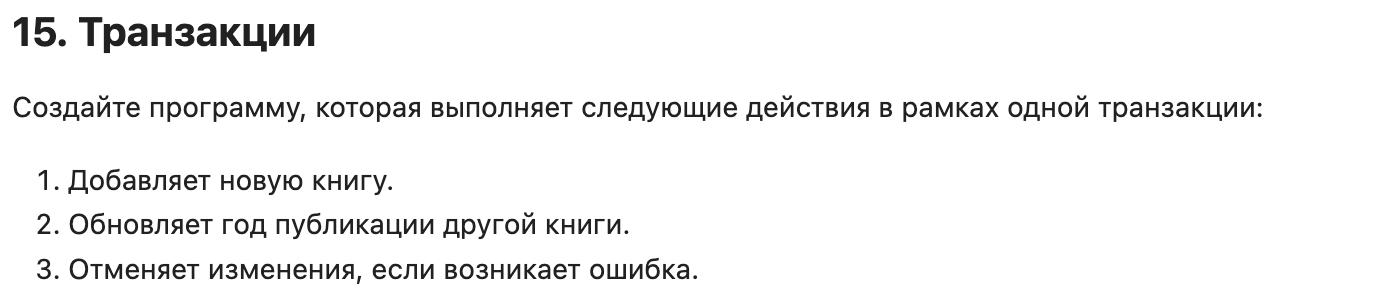

In [169]:
try:
    conn.execute('BEGIN TRANSACTION')
    cursor.execute('''
INSERT INTO books (title, author, year_published, genre)
VALUES ('Crime and punishment', 'Dostoevsky', 1865, 'Classic');
''')

    cursor.execute('''
UPDATE books
SET year_publishedeeeeeeeeeee = 1966
WHERE title = '19842';
''')

except sqlite3.Error as e:
    print(f"\nОшибка транзакции: {e}. Изменения отменены.")
    conn.rollback()

finally:
    cursor.execute('''
SELECT * FROM books
''')

query = """
SELECT *
FROM books_logs
"""

df = pd.read_sql(query, conn)
df


Ошибка транзакции: cannot start a transaction within a transaction. Изменения отменены.


,id,book_id,action,timestamp


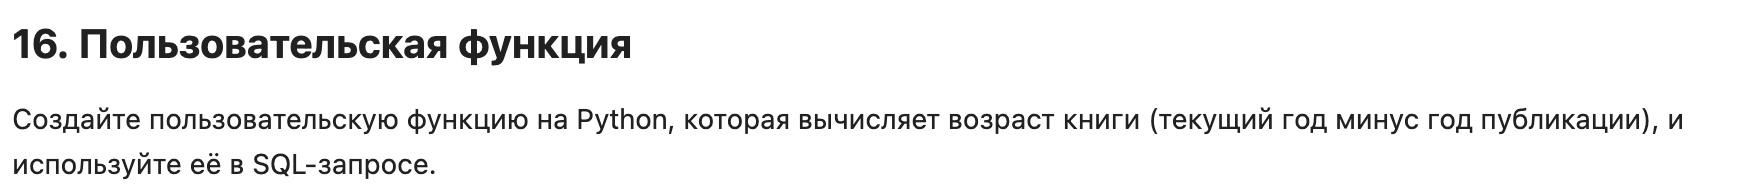

In [170]:
from datetime import datetime

def calculate_book_age(year_published):
    current_year = datetime.now().year
    return current_year - year_published

conn.create_function('book_age', 1, calculate_book_age)

cursor = conn.cursor()

cursor.execute('''
SELECT title, year_published, book_age(year_published)
FROM books
''')
books_with_age = cursor.fetchall()

for book in books_with_age:
    print(f"{book[0]} ({book[1]}): {book[2]} лет")

1984 (1984): 41 лет
To Kill a Mockingbird (1960): 65 лет


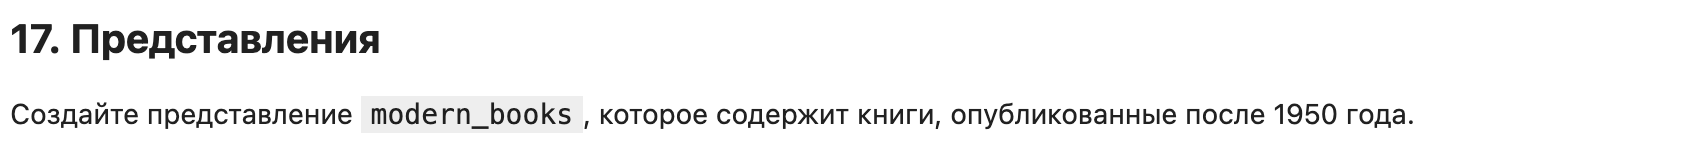

In [171]:
cursor.execute('''
CREATE VIEW IF NOT EXISTS modern_books AS
SELECT * FROM books WHERE year_published > 1950
''')
conn.commit()


cursor.execute('SELECT * FROM modern_books')
modern_books = cursor.fetchall()


for book in modern_books:
    print(book)

conn.close()

(2, '1984', 'George Orwell', 1984, 'Dystopian')
(3, 'To Kill a Mockingbird', 'Harper Lee', 1960, 'Classic')


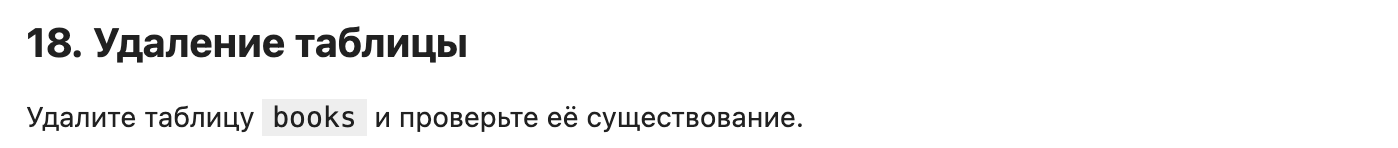
#Если удалить таблицу последующие задания не сработают

In [176]:
conn = sqlite3.connect('library.db')
cursor = conn.cursor()
cursor.execute('DROP TABLE IF EXISTS books')

query = """
SELECT *
FROM books
"""

try:
  df = pd.read_sql(query, conn)
  df
except Exception:
  print("Нет таблицы!")
conn.close()

Нет таблицы!


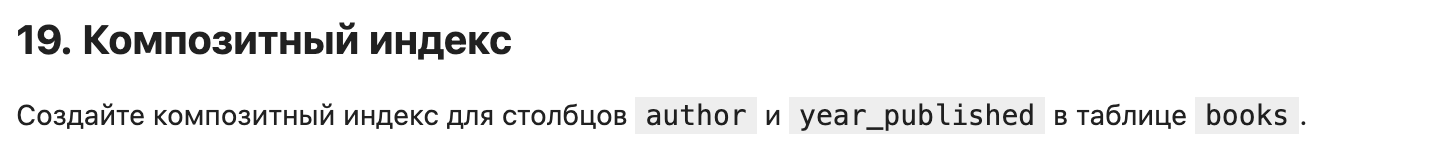

In [173]:
conn = sqlite3.connect('library.db')
cursor = conn.cursor()

cursor.execute('''
CREATE INDEX IF NOT EXISTS idx_author_year
ON books (author, year_published)
''')
conn.commit()
conn.close()

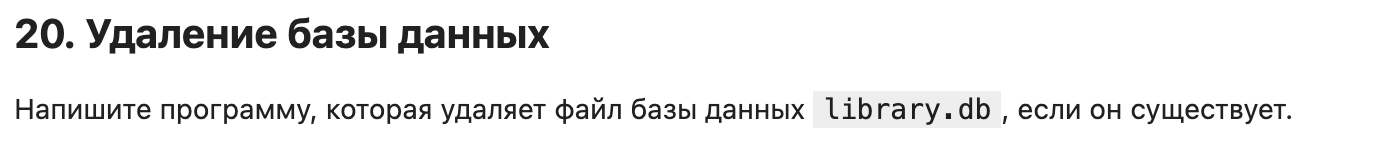

In [174]:
import os
if os.path.exists('library.db'):
    os.remove('library.db')
    print("\nФайл базы данных library.db удален")
else:
    print("\nФайл базы данных library.db не существует")


Файл базы данных library.db удален
